<a href="https://colab.research.google.com/github/Jubi-Wismi/hands-on-sql-3086685/blob/main/dissertationproject1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install flask_ngrok

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [4]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix


In [5]:
# %tensorflow_version 1.x


In [6]:
#path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"
path = "/content/drive/MyDrive/animals"


data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)


df = pd.DataFrame(data)

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

In [7]:
train_df, Temp_df = train_test_split(df,  train_size= 0.70 , shuffle=True, random_state=124)
valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.70 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# print(train_df.shape)
# print(valid_df.shape)
# print(test_df.shape)

print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath       labels
0  /content/drive/MyDrive/animals/grasshopper/2cc...  grasshopper
1  /content/drive/MyDrive/animals/seal/7fd13ce3c2...         seal
2  /content/drive/MyDrive/animals/octopus/71d0d2b...      octopus
3  /content/drive/MyDrive/animals/wolf/0387df115d...         wolf
4  /content/drive/MyDrive/animals/okapi/8c36694b9...        okapi
(3779, 3)
--------Validation----------
                                             imgpath          labels
0  /content/drive/MyDrive/animals/raccoon/1f01736...         raccoon
1  /content/drive/MyDrive/animals/grasshopper/23e...     grasshopper
2  /content/drive/MyDrive/animals/dolphin/0e7f908...         dolphin
3  /content/drive/MyDrive/animals/donkey/3ea2e014...          donkey
4  /content/drive/MyDrive/animals/pelecaniformes/...  pelecaniformes
(1134, 3)
----------Test--------------
                                             imgpath  labels
0  /content/drive/MyDr

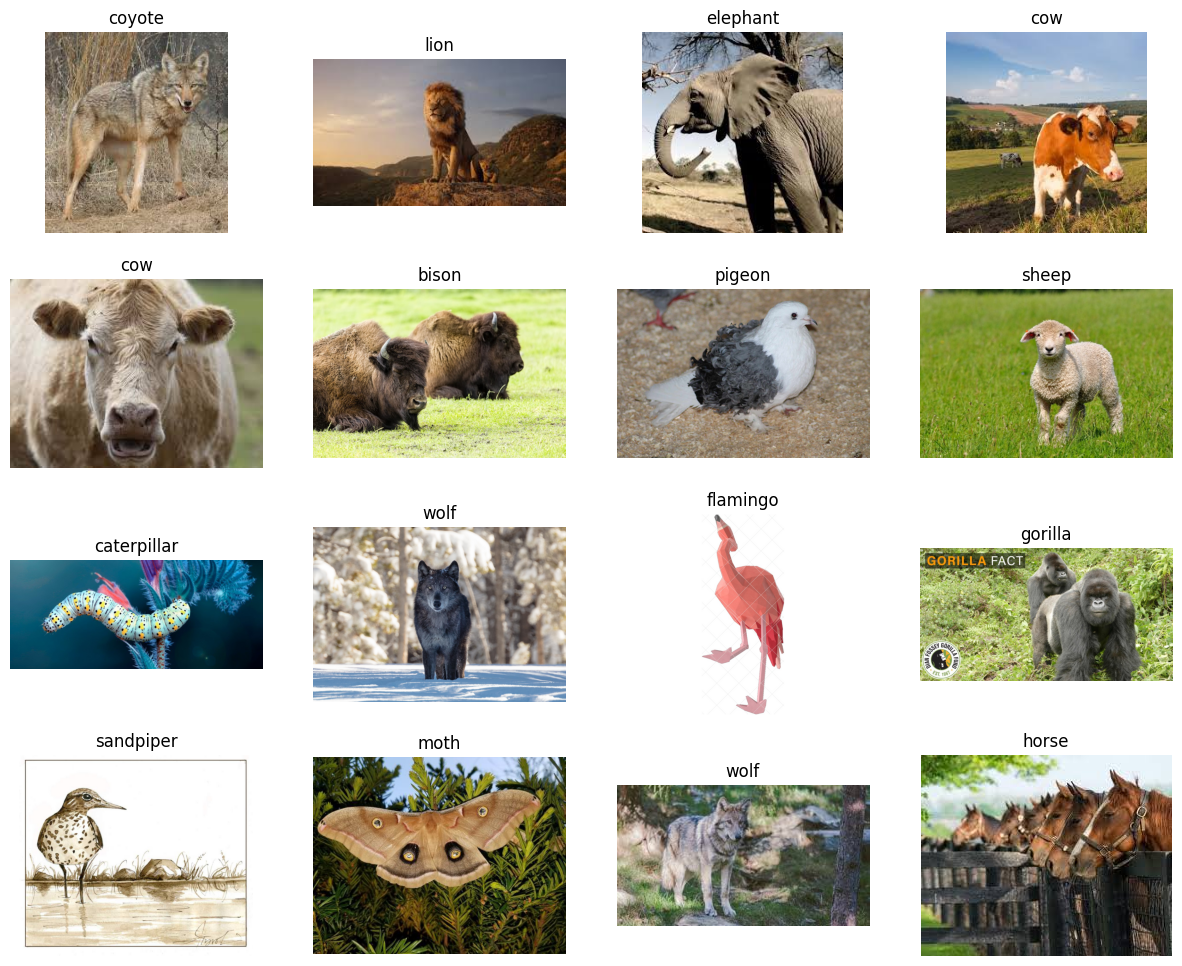

In [8]:
plt.figure(figsize=(15,12))
for i, row in test_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [9]:
# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications.resnet import preprocess_input
mixed_precision.set_global_policy('mixed_float16')


In [10]:
%%time
# from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
BATCH_SIZE = 36
IMAGE_SIZE = (224, 224)



generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,

)



# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 3779 validated image filenames belonging to 90 classes.
Found 1134 validated image filenames belonging to 90 classes.
Found 487 validated image filenames belonging to 90 classes.
CPU times: user 112 ms, sys: 153 ms, total: 265 ms
Wall time: 931 ms


In [11]:

# Load a different pretrained model, for example, ResNet50
pretrained_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Freeze the layers of the pretrained model
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [12]:
num_classes = len(set(train_images.classes))


# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.15),
  layers.experimental.preprocessing.RandomZoom(0.15),
  # layers.experimental.preprocessing.RandomContrast(0.15),
], name='AugmentationLayer')



inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.45)(x)
x = layers.Dense(num_classes)(x)



outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)
 # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)



model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint01')
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                               

In [13]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=15,
    callbacks=[
        EarlyStopping(monitor = "val_loss",
                               patience = 3,
                               restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model.save_weights('./checkpoints/my_checkpointsep30')
model.save("model1.h5")

Epoch 1/15
105/105 [==============================] - 959s 9s/step - loss: 3.5271 - accuracy: 0.2318 - val_loss: 2.1039 - val_accuracy: 0.4709 - lr: 5.0000e-04
Epoch 2/15
105/105 [==============================] - 38s 360ms/step - loss: 1.7721 - accuracy: 0.5962 - val_loss: 1.1125 - val_accuracy: 0.7231 - lr: 5.0000e-04
Epoch 3/15
105/105 [==============================] - 42s 406ms/step - loss: 1.2577 - accuracy: 0.7124 - val_loss: 0.9008 - val_accuracy: 0.7751 - lr: 5.0000e-04
Epoch 4/15
105/105 [==============================] - 39s 369ms/step - loss: 0.9993 - accuracy: 0.7743 - val_loss: 0.8363 - val_accuracy: 0.7778 - lr: 5.0000e-04
Epoch 5/15
105/105 [==============================] - 40s 384ms/step - loss: 0.7998 - accuracy: 0.8177 - val_loss: 0.8100 - val_accuracy: 0.7795 - lr: 5.0000e-04
Epoch 6/15
105/105 [==============================] - 39s 375ms/step - loss: 0.6867 - accuracy: 0.8465 - val_loss: 0.6676 - val_accuracy: 0.8280 - lr: 5.0000e-04
Epoch 7/15
105/105 [==========

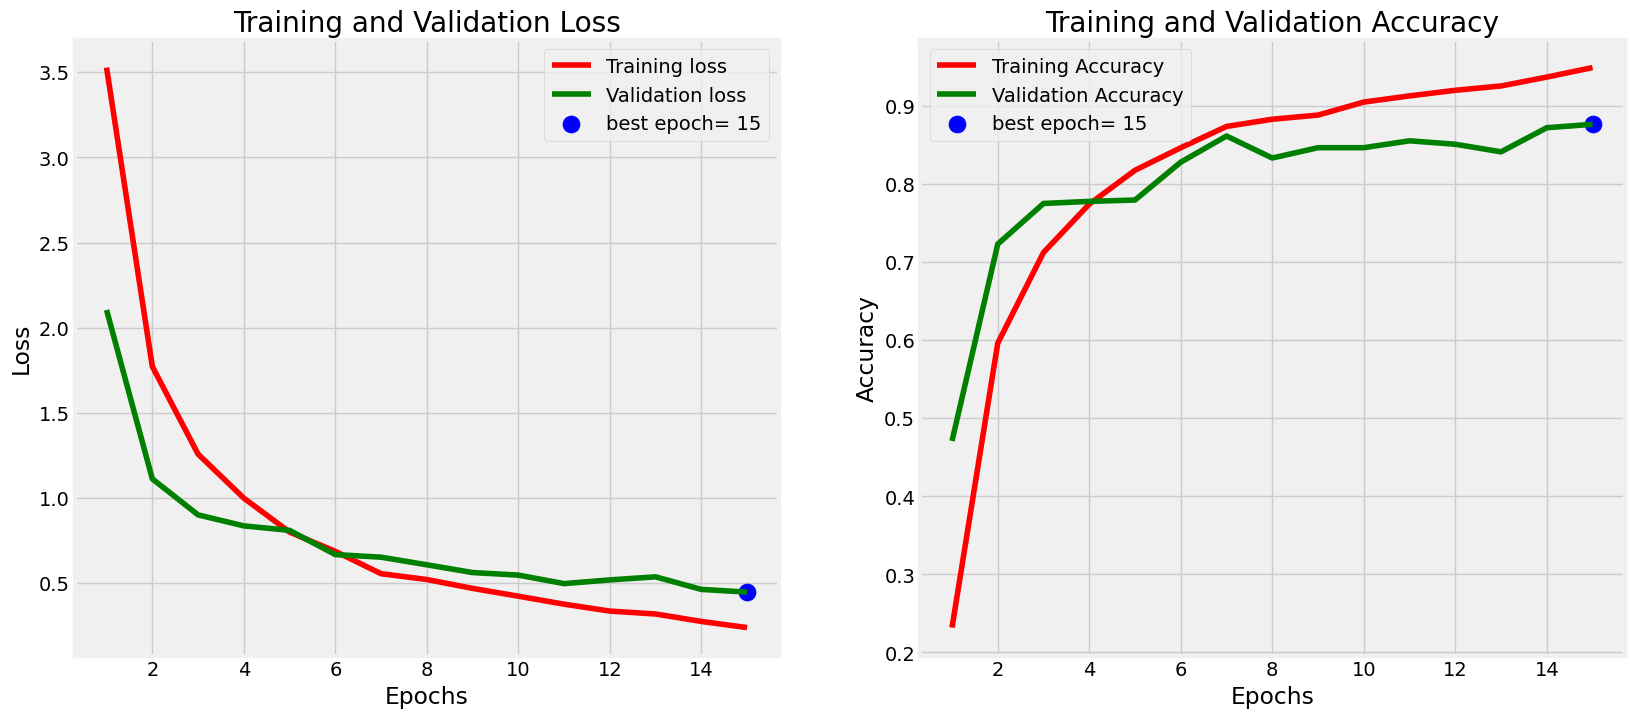

In [14]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [15]:
# pretrained_model.trainable = True
# for layer in pretrained_model.layers:
#     if isinstance(layer, layers.BatchNormalization): # set BatchNorm layers as not trainable
#         layer.trainable = False

# # let`s see first 10 layers
# for l in pretrained_model.layers[:10]:
#     print(l.name, l.trainable)

# model.compile(
#     optimizer=Adam(0.00001), # fine tuning requires very little learning rate
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )
# # model.load_weights('./checkpoints/my_checkpoint')
# print(model.summary())
# history = model.fit(
#     train_images,
#     steps_per_epoch=len(train_images),
#     validation_data=val_images,
#     validation_steps=len(val_images),
#     epochs=20,
#     callbacks=[
#         EarlyStopping(monitor = "val_loss", # watch the val loss metric
#                                patience = 3,
#                                restore_best_weights = True), # if val loss decreases for 5 epochs in a row, stop training,
#         ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
#     ]
# )
# model.save_weights('./checkpoints/my_checkpointsep31')
# model.save("model.hsep3")

In [16]:
# # Define needed variables
# tr_acc = history.history['accuracy']
# tr_loss = history.history['loss']
# val_acc = history.history['val_accuracy']
# val_loss = history.history['val_loss']
# index_loss = np.argmin(val_loss)
# val_lowest = val_loss[index_loss]
# index_acc = np.argmax(val_acc)
# acc_highest = val_acc[index_acc]
# Epochs = [i+1 for i in range(len(tr_acc))]
# loss_label = f'best epoch= {str(index_loss + 1)}'
# acc_label = f'best epoch= {str(index_acc + 1)}'

# # Plot training history
# plt.figure(figsize= (20, 8))
# plt.style.use('fivethirtyeight')

# plt.subplot(1, 2, 1)
# plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
# plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
# plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
# plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
# plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout
# plt.show()

In [17]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))


    Test Loss: 0.47869
Test Accuracy: 86.65%


In [18]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))


14/14 [==============================] - 5s 259ms/step
F1 Score: 0.8649537425079221
                precision    recall  f1-score   support

      antelope       0.86      0.75      0.80         8
        badger       0.75      0.60      0.67         5
           bat       1.00      1.00      1.00         3
          bear       1.00      1.00      1.00         6
           bee       1.00      1.00      1.00         3
        beetle       0.88      1.00      0.93         7
         bison       1.00      0.86      0.92         7
          boar       1.00      1.00      1.00         4
     butterfly       1.00      0.71      0.83         7
           cat       1.00      1.00      1.00         2
   caterpillar       1.00      0.67      0.80         6
    chimpanzee       0.75      1.00      0.86         3
     cockroach       1.00      1.00      1.00         4
           cow       0.71      0.71      0.71         7
        coyote       1.00      0.71      0.83         7
          crab     

In [19]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))),
                            "Test Labels" : test_images.labels,
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

14/14 [==============================] - 4s 308ms/step


Image Index  Test Labels Test Classes  Prediction Labels  \
0            0           14       coyote                 14   
1            1            1       badger                  1   
2            2           81         swan                 81   
3            3            7         boar                  7   
4            4           20       donkey                 20   
5            5           29     goldfish                 29   
6            6           53        okapi                 53   
7            7           28         goat                 28   

  Prediction Classes                                               Path  \
0             coyote  /content/drive/MyDrive/animals/coyote/81f495ab...   
1             badger  /content/drive/MyDrive/animals/badger/68d85c37...   
2               swan  /content/drive/MyDrive/animals/swan/3d41996928...   
3               boar  /content/drive/MyDrive/animals/boar/149cf25549...   
4             donkey  /content/drive/MyDrive/animals/donkey/102a41e3...   
5           goldfish  /content/drive/MyDrive/animals/goldfish/0f6446...   
6              okapi  /content/drive/MyDrive/animals/okapi/8e737aeec...   
7               goat  /content/drive/MyDrive/animals/goat/9ffa8a9f5f...   

   Prediction Probability  
0                0.948218  
1                0.974197  
2                0.982025  
3                0.998984  
4                0.851940  
5                0.997285  
6                0.829336  
7                0.907395

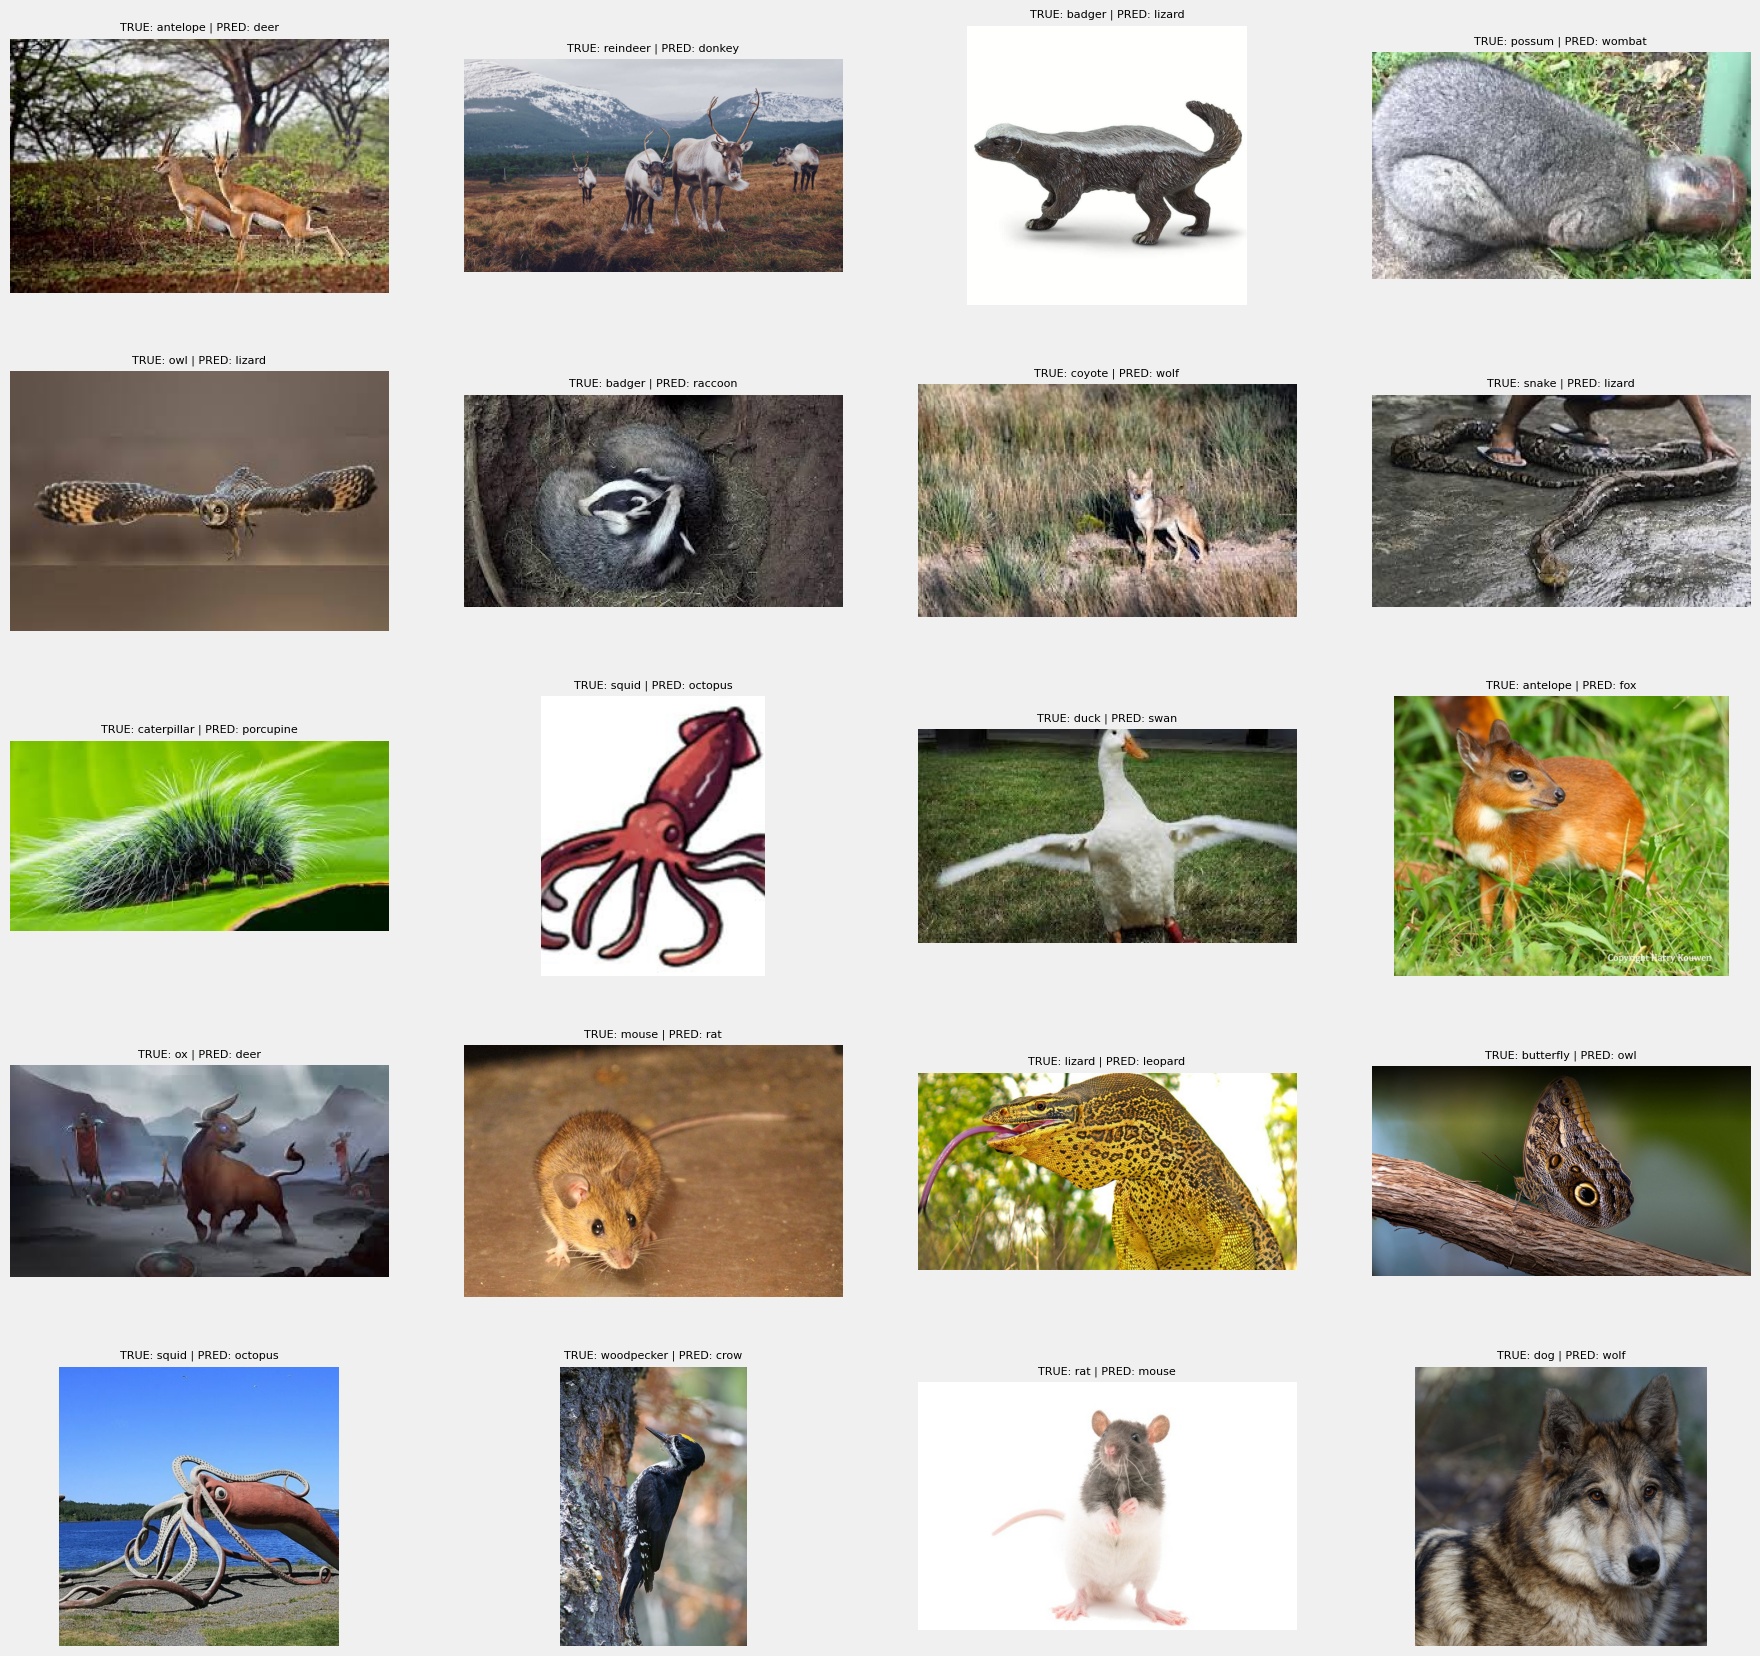

In [20]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')

plt.show()

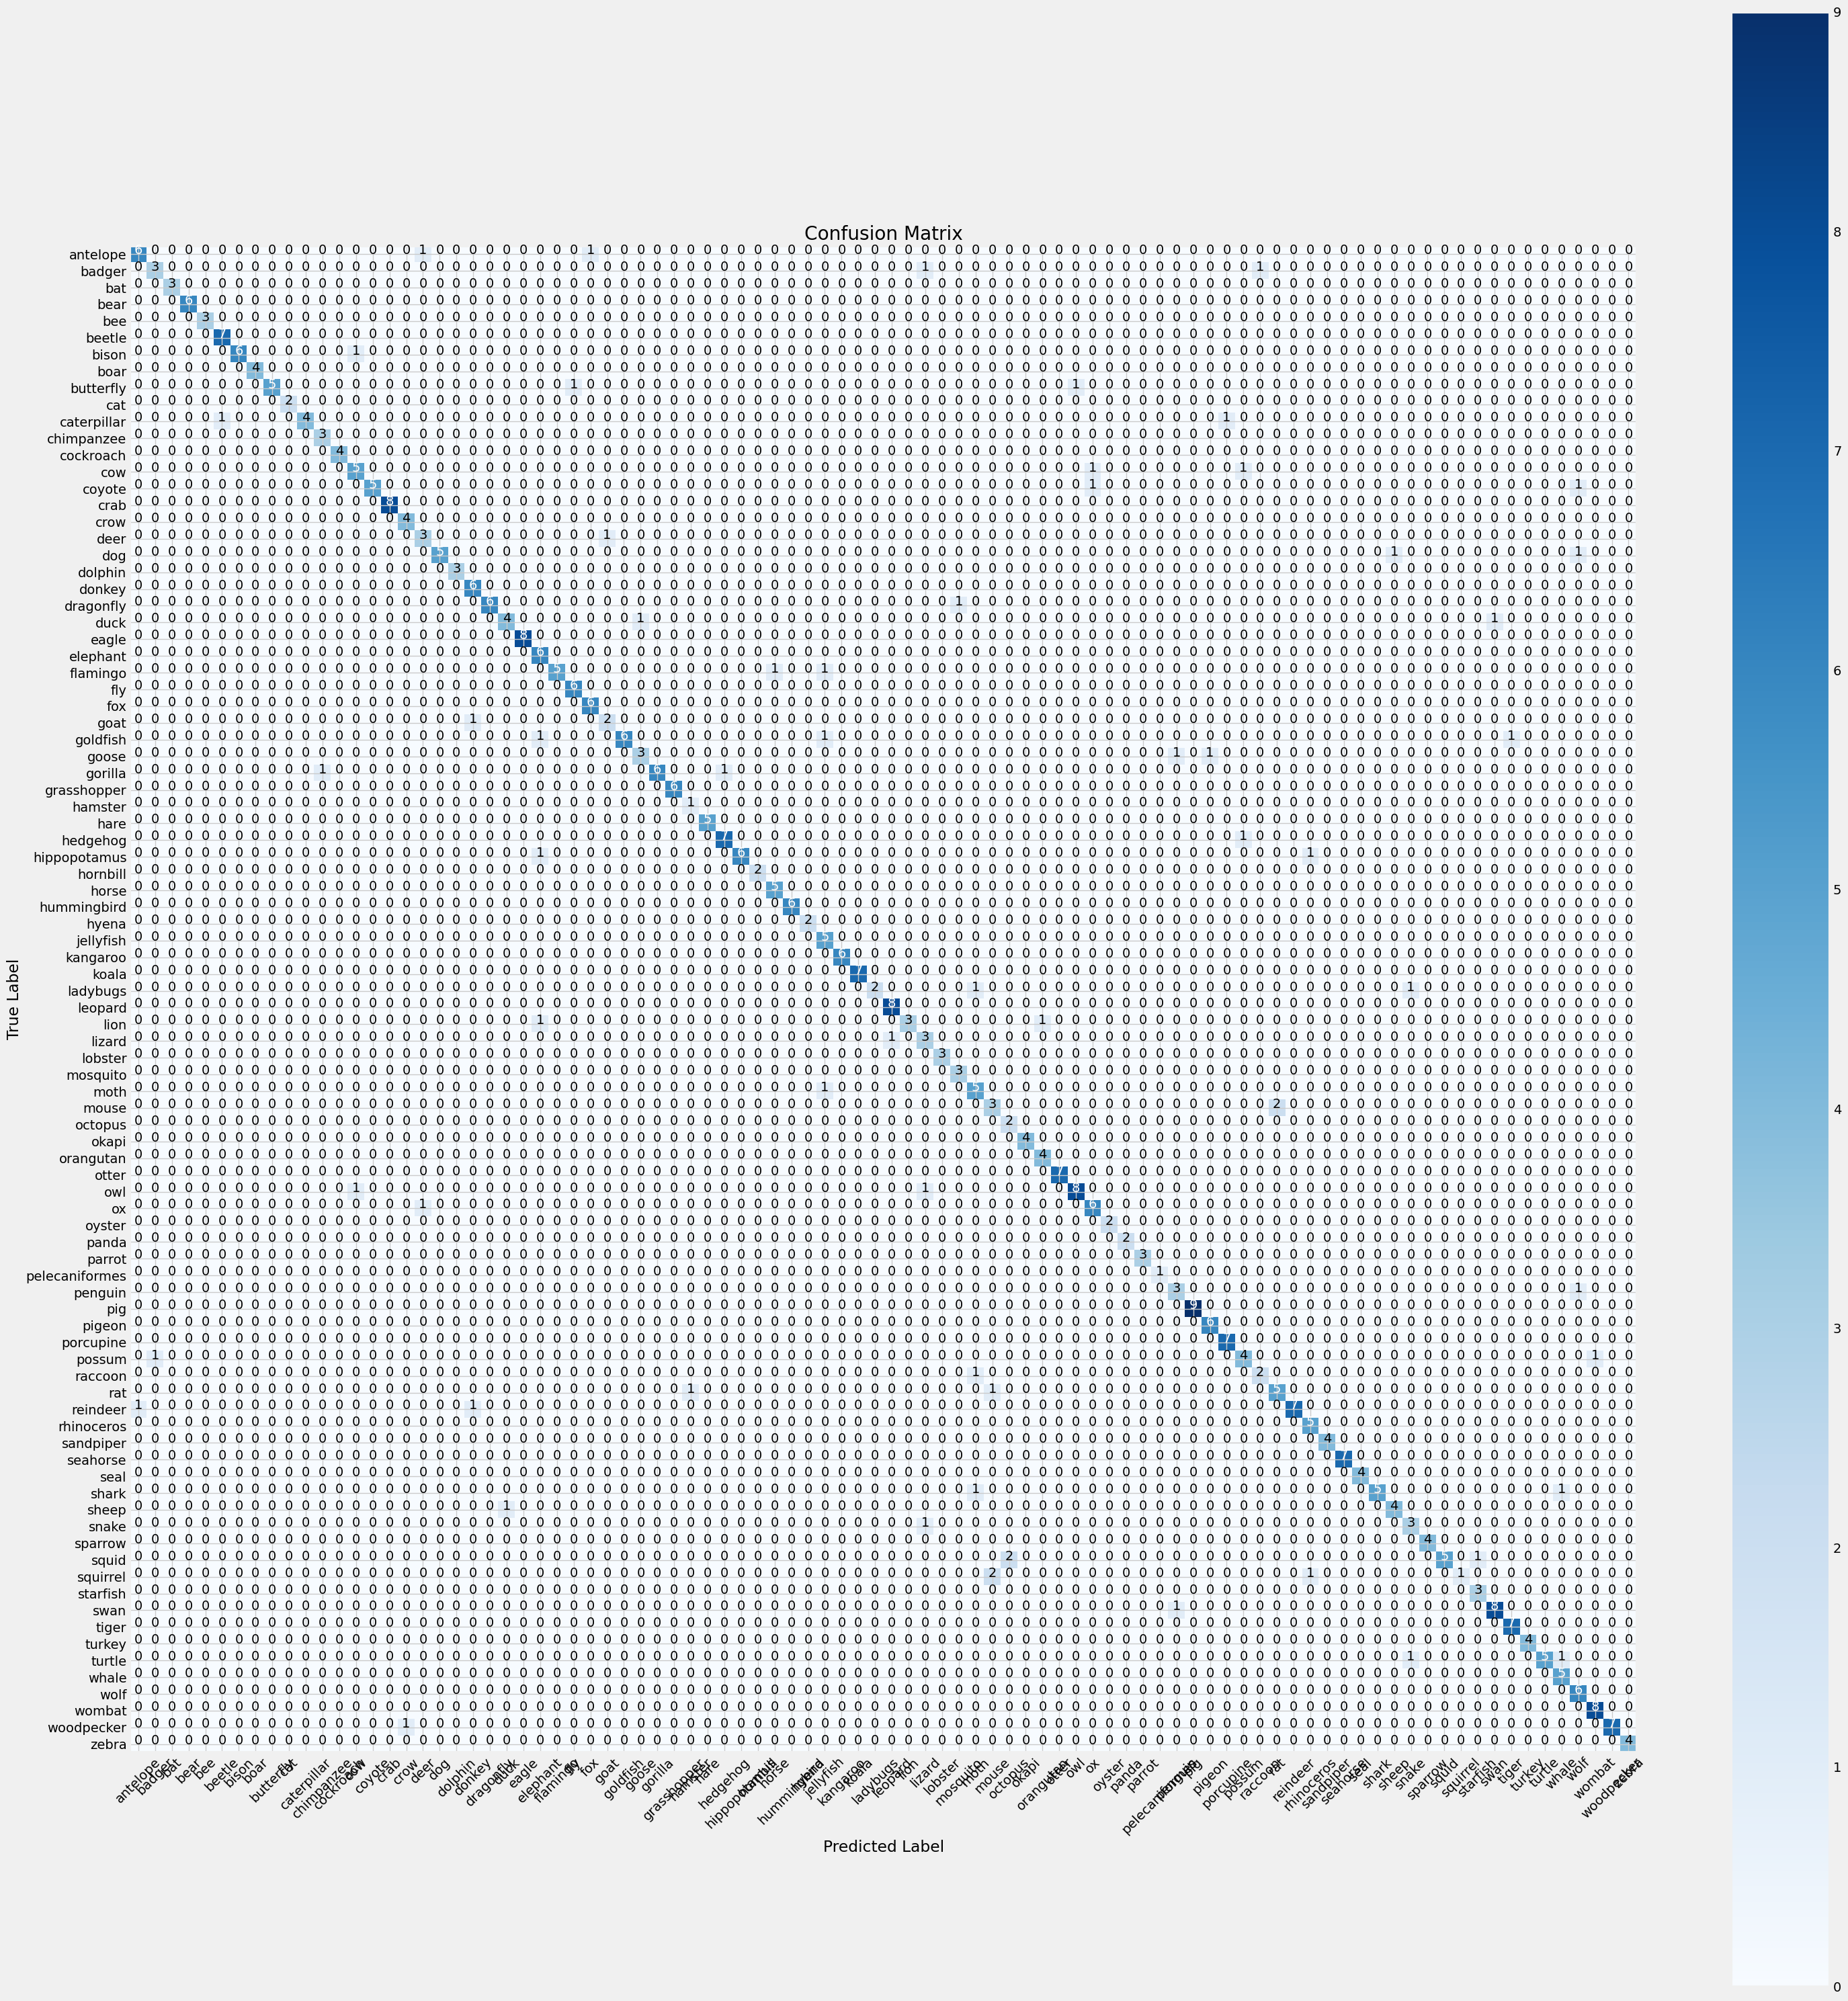

In [21]:
preds = model.predict_generator(test_images)
y_pred = np.argmax(preds, axis=1)
g_dict = test_images.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_images.classes, y_pred)

plt.figure(figsize= (30, 30))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [22]:
%mkdir templates -p

In [23]:
%%writefile templates/index.html


#UserInterface
<!DOCTYPE HTML>

<html>

	<head>
		<title> </title>
		<meta http-equiv="content-type" content="text/html; charset=utf-8" />
		<meta name="description" content="" />
		<meta name="keywords" content="" />
		<!--[if lte IE 8]><script src="css/ie/html5shiv.js"></script><![endif]-->
		<script src="js/jquery.min.js"></script>
		<script src="js/jquery.dropotron.min.js"></script>
		<script src="js/jquery.scrollgress.min.js"></script>
		<script src="js/jquery.scrolly.min.js"></script>
		<script src="js/jquery.slidertron.min.js"></script>
		<script src="js/skel.min.js"></script>
		<script src="js/skel-layers.min.js"></script>
		<script src="js/init.js"></script>
		<noscript>
			<link rel="stylesheet" href="css/skel.css" />
			<link rel="stylesheet" href="css/style.css" />
			<link rel="stylesheet" href="css/style-xlarge.css" />
		</noscript>
		<!--[if lte IE 9]><link rel="stylesheet" href="css/ie/v9.css" /><![endif]-->
		<!--[if lte IE 8]><link rel="stylesheet" href="css/ie/v8.css" /><![endif]-->
	</head>
	<body class="landing">

		<!-- Header -->
			<header id="header" class="alt skel-layers-fixed">
				<h1><a href="index.html">Animal Species Predictor <span></span></a></h1>

			</header>

		<!-- Banner -->
			<section id="banner">
				<div class="inner">
					<h2>Animal Species Predictor</h2>
					<p></p>

					<h1>Upload an Image of an Animal</h1>
    <input type="file" id="imageInput">
    <button onclick="predictSpecies()">Predict</button>
    <p id="predictionResult"></p>



     <script>
        function predictSpecies() {
            const input = document.getElementById('imageInput');
            const file = input.files[0];

            if (!file) {
                alert('Please select an image to upload.');
                return;
            }

            const apiKey = 'YOUR_CLARIFAI_API_KEY'; // Replace with your Clarifai API key
            const formData = new FormData();
            formData.append('image', file);

            fetch('https://api.clarifai.com/v2/models/aaa03c23b3724a16a56b629203edc62c/outputs', {
                method: 'POST',
                headers: {
                    'Authorization': `Key ${apiKey}`
                },
                body: formData
            })
            .then(response => response.json())
            .then(data => {
                const predictions = data.outputs[0].data.concepts;
                const topPrediction = predictions[0].name;
                document.getElementById('predictionResult').textContent = `Predicted Species: ${topPrediction}`;
            })
            .catch(error => {
                console.error('Error:', error);
            });
        }
    </script>








		<!-- Footer -->
			<footer id="footer">

				<span class="copyright">
					&copy; Copyright. All rights reserved. Design by Jubi Wismi</a>
				</span>
			</footer>

	</body>

</html>

Overwriting templates/index.html


In [24]:
import os
import threading

In [25]:
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=486f353ef81d15550c5d6fdffde9e2d5d692bbd731b2313ec84a014b4de754b0
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok


In [26]:
# from joblib.parallel import threading
# from flask import Flask,render_template
# from pyngrok import ngrok
# os.environ["FLASK_ENV"]= 'development'
# # os.environ["FLASK_DEBUG"]= 'development'
# app = Flask(__name__)
# port =5000
# ngrok.set_auth_token("2Uqd3fl0qTyjr8tucf0pn4i6PCN_7s6zLoivfuFaMV2un48ZY")
# public_url =ngrok.connect(port).public_url
# print(" * ngrok \ "{}"- \"http://127.0.0.1:{}\"".format(public_url,port))
# # print(public_url,port)
# app.config["BASE_URL"]=public_url

# @app.route("/")
# def index():
#   return render_template("index.html")

#   threading.Thread(target=app.run,kwargs={"use_reloader" : False }).start()

In [27]:
import os
from threading import Thread
from flask import Flask, render_template
from pyngrok import ngrok

os.environ["FLASK_ENV"] = 'development'
app = Flask(__name__)
port = 5000
ngrok.set_auth_token("2Uqd3fl0qTyjr8tucf0pn4i6PCN_7s6zLoivfuFaMV2un48ZY")
public_url = ngrok.connect(port).public_url
print(" * ngrok - {}".format(public_url))

app.config["BASE_URL"] = public_url

@app.route("/")
def index():
    return render_template("index.html")

if __name__ == "__main__":
    Thread(target=app.run, kwargs={"use_reloader": False}).start()


'FLASK_ENV' is deprecated and will not be used in Flask 2.3. Use 'FLASK_DEBUG' instead.


 * ngrok - https://be31-35-194-31-35.ngrok-free.app


In [28]:
# !ls
!curl -s https://ngrok-agent.s3.amazonaws.com/ngrok.asc | sudo tee /etc/apt/trusted.gpg.d/ngrok.asc >/dev/null && echo "deb https://ngrok-agent.s3.amazonaws.com buster main" | sudo tee /etc/apt/sources.list.d/ngrok.list && sudo apt update && sudo apt install ngrok

 * Serving Flask app '__main__'
 * Debug mode: on


'FLASK_ENV' is deprecated and will not be used in Flask 2.3. Use 'FLASK_DEBUG' instead.
'FLASK_ENV' is deprecated and will not be used in Flask 2.3. Use 'FLASK_DEBUG' instead.
INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


deb https://ngrok-agent.s3.amazonaws.com buster main
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 https://ngrok-agent.s3.amazonaws.com buster InRelease [20.3 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [995 kB]
Hit:9 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,251 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [915 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Package

In [29]:
!ls


 AnimalDectection90.ipynb				  model.h6
 animal-image-classification-using-efficientnetb7.ipynb   rudo.ipynb
 bardanimad90.ipynb					  templates
 bardnew90.ipynb					  Untitled0.ipynb
 checkpoints						  Untitled1.ipynb
'Copy of AnimalDectection90 (1).ipynb'			  Untitled2.ipynb
'Copy of AnimalDectection90final.ipynb'			  Untitled3.ipynb
'Copy of AnimalDectection90.ipynb'			  Untitled4.ipynb
 dissertationproject.ipynb				  Untitled5.ipynb
 grad-cam-what-do-cnns-see.ipynb			  Untitled6.ipynb
'Identify the Animal_colab.ipynb'			  Untitled7.ipynb
 model.h01						  Untitled8.ipynb
 model.h5						  Untitled9.ipynb


In [30]:
!ngrok config add-authtoken 2Uqd3fl0qTyjr8tucf0pn4i6PCN_7s6zLoivfuFaMV2un48ZY


Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [31]:
from flask_ngrok import run_with_ngrok
from flask import Flask


app = Flask(__name__)


run_with_ngrok(app)
@app.route("/")

def home():
  return f"Running Flask on Google Colab!"

app.run()

ModuleNotFoundError: ignored